In [1]:
%matplotlib inline
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.onnx as onnx
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
train_data = datasets.MNIST(
    root='data',
    transform=ToTensor(),
    train=True,
    download=True
)

test_data = datasets.MNIST(
    root='data',
    transform=ToTensor(),
    train=False,
    download=True
)

In [3]:
train_data.data.shape

torch.Size([60000, 28, 28])

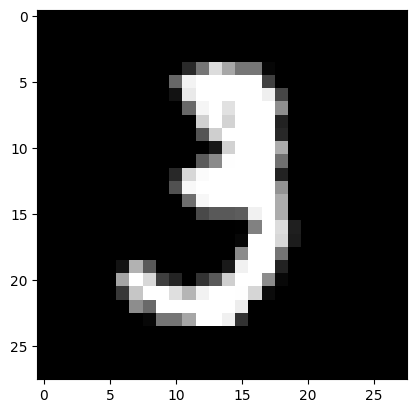

In [4]:
plt.imshow(train_data.data[10], cmap='gray')

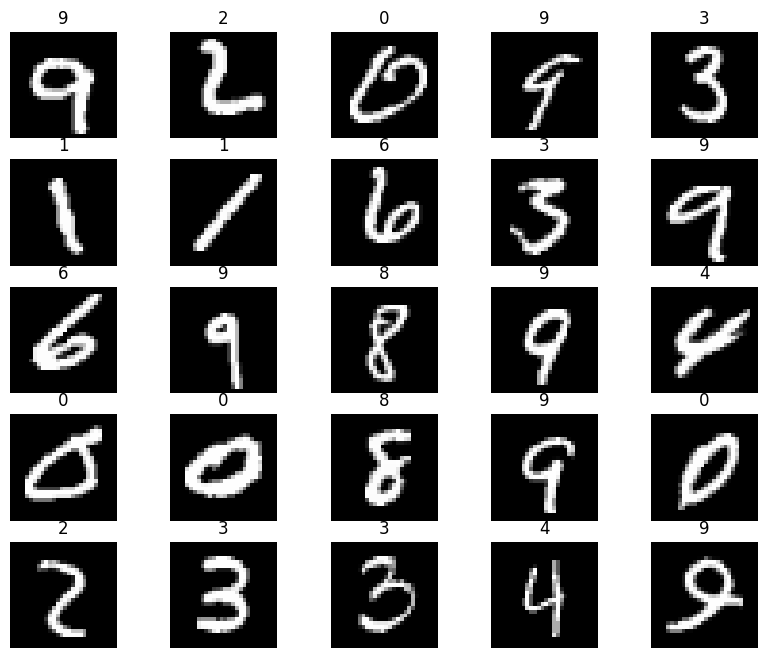

In [5]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
train_loader = DataLoader(train_data, 64, shuffle=True)
test_loader = DataLoader(test_data, 64, shuffle=True)

In [7]:
class ModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.network(self.flatten(x))

In [8]:
%%writefile ../service/model.py
"""
This file was generated in mnist.ipynb
Don't change this file directly.
"""
import torch
from torch import nn


class ModelV2(nn.Module):
    """ Implementation of TinyVGG """
    def __init__(self, input_shape: int, hidden_units: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 7 * 7, 10)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

Overwriting ../service/model.py


In [9]:
from service.model import ModelV2
model = ModelV2(1, 10)
model

ModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [10]:
def train(model, dataloader, loss_fn, optimizer):
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    return train_loss / len(dataloader),  train_acc / len(dataloader)


In [11]:
def test(model, dataloader, loss_fn):
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    return test_loss / len(dataloader),  test_acc / len(dataloader)


In [30]:
from tqdm.auto import tqdm

def fit(model, epochs, train_loader, test_loader, optimizer, writer=None):
    for epoch in tqdm(range(epochs)):
        print(f"Epoch {epoch}:")
        train_loss, train_acc = train(model, train_loader, loss_fn, optimizer)
        test_loss, test_acc = test(model, test_loader, loss_fn)
        print(f"[Train] Accuracy: {(train_acc * 100):>0.1f}%, Avg loss: {train_loss:>8f}")
        print(f"[Test] Accuracy: {(test_acc * 100):>0.1f}%, Avg loss: {test_loss:>8f} \n")

        if writer:
            writer.add_scalars('Loss', {'train_loss': train_loss, 'test_loss': test_loss}, epoch)
            writer.add_scalars('Accuracy', {'train_acc': train_acc, 'test_acc': test_acc}, epoch)
            writer.add_graph(model, torch.randn(64, 1, 28, 28))
            writer.close()


In [38]:
from torch.utils.tensorboard import SummaryWriter

torch.manual_seed(42)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
writer = SummaryWriter(log_dir='logs')

fit(model, 15, train_loader, test_loader, optimizer, writer)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0:
[Train] Accuracy: 98.3%, Avg loss: 0.057112
[Test] Accuracy: 97.8%, Avg loss: 0.075097 

Epoch 1:
[Train] Accuracy: 98.3%, Avg loss: 0.056100
[Test] Accuracy: 98.2%, Avg loss: 0.058731 

Epoch 2:
[Train] Accuracy: 98.4%, Avg loss: 0.053321
[Test] Accuracy: 98.1%, Avg loss: 0.068627 

Epoch 3:
[Train] Accuracy: 98.4%, Avg loss: 0.055581
[Test] Accuracy: 98.3%, Avg loss: 0.054798 

Epoch 4:
[Train] Accuracy: 98.4%, Avg loss: 0.055628
[Test] Accuracy: 98.1%, Avg loss: 0.062094 

Epoch 5:
[Train] Accuracy: 98.3%, Avg loss: 0.058553
[Test] Accuracy: 98.2%, Avg loss: 0.064407 

Epoch 6:
[Train] Accuracy: 98.4%, Avg loss: 0.053430
[Test] Accuracy: 97.9%, Avg loss: 0.066242 

Epoch 7:
[Train] Accuracy: 98.4%, Avg loss: 0.053712
[Test] Accuracy: 98.0%, Avg loss: 0.085183 

Epoch 8:
[Train] Accuracy: 98.4%, Avg loss: 0.054146
[Test] Accuracy: 98.4%, Avg loss: 0.069790 

Epoch 9:
[Train] Accuracy: 98.4%, Avg loss: 0.053480
[Test] Accuracy: 98.2%, Avg loss: 0.065651 

Epoch 10:
[Train] Ac

In [37]:
%load_ext tensorboard
%tensorboard --logdir logs --port 6007

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

In [39]:
from torchinfo import summary
summary(model, input_size=(64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ModelV2                                  [64, 10]                  --
├─Sequential: 1-1                        [64, 10, 14, 14]          --
│    └─Conv2d: 2-1                       [64, 10, 28, 28]          100
│    └─ReLU: 2-2                         [64, 10, 28, 28]          --
│    └─Conv2d: 2-3                       [64, 10, 28, 28]          910
│    └─ReLU: 2-4                         [64, 10, 28, 28]          --
│    └─MaxPool2d: 2-5                    [64, 10, 14, 14]          --
├─Sequential: 1-2                        [64, 10, 7, 7]            --
│    └─Conv2d: 2-6                       [64, 10, 14, 14]          910
│    └─ReLU: 2-7                         [64, 10, 14, 14]          --
│    └─Conv2d: 2-8                       [64, 10, 14, 14]          910
│    └─ReLU: 2-9                         [64, 10, 14, 14]          --
│    └─MaxPool2d: 2-10                   [64, 10, 7, 7]            --
├─Sequentia

torch.Size([1, 1, 28, 28])
0


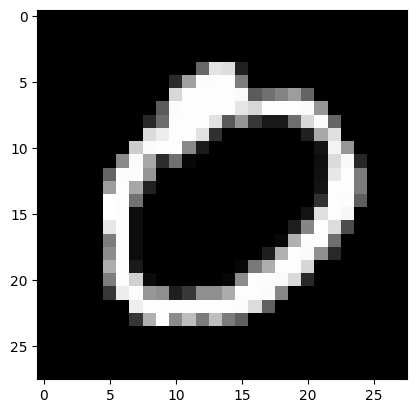

In [40]:
sample = next(iter(test_loader))[0][12][0]
prediction = model(sample.unsqueeze(0).unsqueeze(0))
print(sample.unsqueeze(0).unsqueeze(0).shape)
print(prediction.argmax().item())

plt.imshow(sample, cmap='gray')

In [41]:
# input_image = torch.zeros((1, 1, 28, 28))
# onnx.export(model, input_image, '../service/model.onnx')

In [42]:
# model.state_dict()

In [43]:
torch.save(obj=model.state_dict(), f='../service/model.pth')